In [1]:
###the folllowing libraries will be neeeded
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# Fault reactivation $\frac{\sigma_d}{\tau}$

###  The equations and notes used in the code were based from the lecture [notes](https://dnicolasespinoza.github.io/IPG.html) by professor Nicholas Espinoza

The 3D mohr circle can be used to obtain the solutions of normal stresses and shear stresses on a given plane. Altough geometrically simple it is only preffered when the plane in question happens to be colinear with a principal stress. If the plane happens to intersect the element at an oblique angle to the principal stresses, linear algebra is necessesary to obtain  $\frac{\sigma_d}{\tau}$

The following functions outlines the procedure in plotting the mohr circle. 

### Type of fault

It is importat to determine which kind of fault regime we are deeling with. A simple if function takes care of this.

In [2]:
def TypeFaulting(Sv,S_hmax,S_hmin):
    if Sv>S_hmax and Sv>S_hmin:
        fault_regime=['normal']
        S1=Sv
        S2=S_hmax
        S3=S_hmin
    elif S_hmax>Sv and S_hmin>Sv:
        fault_regime=['reverse']
        S1=S_hmax
        S2=S_hmin
        S3=Sv
    elif S_hmax>Sv and Sv>S_hmin:
        fault_regime=['strike']
        S1=S_hmax
        S2=Sv
        S3=S_hmin
    return S1,S2,S3,fault_regime

### Mohr Circles

Once the S1, S2, S3 the mohr circle can be plotted, simple geometry is used. The center and radious of each circle is obtained, then a simple array with all anlges ranging from 0 to 180 degrees is created and the perimeter of each circle is plotted. The criterion line is used to determine which faults are at risk of slipping. This line can be plotted by using the coeficient of friction, since at large scale the earth is already broken, no cohesive strenght is present and thus the line can be simply expressed by $\tau=\mu*\sigma_d$

Once the oultines of the mohr circle can be found the ratio $\frac{\sigma_d}{\tau}$ can be displayed as a gradient with the redder colors having a higher values than the blue ones. To do this a simple mesh grid is applied.

In [3]:
def MohrCircle(S1,S2,S3,Pp,mu):
    #mohr circle outlines
    c1=((S1-Pp)+(S3-Pp))/2; r1=((S1-Pp)-(S3-Pp))/2; c2=((S1-Pp)+(S2-Pp))/2; r2=((S1-Pp)-(S2-Pp))/2
    c3=((S2-Pp)+(S3-Pp))/2; r3=((S2-Pp)-(S3-Pp))/2; angles=np.linspace(0, np.pi, num=100)
    
    circle_1x=r1*np.cos(angles)+c1; circle_1y=r1*np.sin(angles)
    circle_2x=r2*np.cos(angles)+c2; circle_2y=r2*np.sin(angles)  
    circle_3x=r3*np.cos(angles)+c3; circle_3y=r3*np.sin(angles)
    
    #critereron line
    sig_n=np.linspace(0, 1.1*(S1-Pp), num=100); tau=mu*sig_n

    #Creating the mesh grid for the 3 different circles
    R=np.linspace(0,r1, num=100); Theta,Rad_g=np.meshgrid(angles,R)
    Y1=Rad_g*np.sin(Theta); X1=Rad_g*np.cos(Theta)+c1; Z1=np.divide(Y1, X1)
    
    #the inside of these two circles are not projected thus they are simple used to be superimposed and be empty space
    R=np.linspace(0,r2,num=100); Theta,Rad_g=np.meshgrid(angles,R);
    Y2=Rad_g*np.sin(Theta); X2=Rad_g*np.cos(Theta)+c2; Z2=np.divide(Y2, X2)-np.divide(Y2, X2)
    R=np.linspace(0,r3,num=100); Theta,Rad_g=np.meshgrid(angles,R)
    Y3=Rad_g*np.sin(Theta); X3=Rad_g*np.cos(Theta)+c3; Z3=np.divide(Y3, X3)-np.divide(Y3, X3)
    
    #plotting all the values
    plt.plot()
    plt.pcolor(X1,Y1,Z1, cmap='jet')
    plt.pcolor(X2,Y2,Z2, cmap='binary')
    plt.pcolor(X3,Y3,Z3, cmap='binary')
    plt.plot(circle_1x,circle_1y,'b',circle_2x,circle_2y,'r',circle_3x,circle_3y,'k',
             sig_n,tau,'g');
    axes = plt.axes()
    axes.set_xlim([0, 1.1*(S1-Pp)])
    axes.set_ylim([0,0.5*(S1-Pp)])
    return


### Tensor Method
Now that there is a graphical representation of $\frac{\sigma_d}{\tau}$ what if we want to plot an oblique fault and see were it falls?. The following code uses the Tensor Method to solve for $\sigma_d$ and $\tau$ (*for simplicity it is assumed $S_v$ is a principal stress*)

First the orientation of principal stresses with respect to the geographical coordinate system. These angles are related to the azimuth of $S_{hmin}$ $S_{hmax}$ and the respective fault regime. A simple if function takes care of this.
The azimuths are given in azimuth notation ranging from 0 to 180 degrees

In [4]:
def angle_transform(fault_regime,azimuth_shmax,azimuth_shmin):
    if fault_regime==['normal']:
        a=azimuth_shmin/180*np.pi; #gotta convert to radians
        b=np.pi/2;
        y=0;
    elif fault_regime==['strike']:
        a=azimuth_shmax/180*np.pi;
        b=0;
        y=np.pi/2;
    elif fault_regime==['reverse']:
        a=azimuth_shmax/180*np.pi ;
        b=0;
        y=0;
    return a,b,y

Once the angles have been determined the change of basis matrix $R_{pg}$, and stress tensor in geographic cordinates $S_G$, can be caulcated using the the principal stress Matrix and linear algebra. For more information plese refer to proffesor Espinoza [5.2.1](https://dnicolasespinoza.github.io/node37.html#SECTION00642000000000000000)


In [5]:
def Matrix_transforms(S1,S2,S3,a,b,y):
    S_p=np.matrix([[S1,0,0],
                      [0,S2,0],
                      [0,0,S3]])
    
    Rpg=np.array([[np.cos(a)*np.cos(b), np.sin(a)*np.cos(b), -1*np.sin(b)],
                [np.cos(a)*np.sin(b)*np.sin(y)-np.sin(a)*np.cos(y), np.sin(a)*np.sin(b)*np.sin(y)+np.cos(a)*np.cos(y), np.cos(b)*np.sin(y)],
                [np.cos(a)*np.sin(b)*np.cos(y)+np.sin(a)*np.sin(y), np.sin(a)*np.sin(b)*np.cos(y)-np.cos(a)*np.sin(y), np.cos(b)*np.cos(y)]])
    #Rpg=np.matrix.round(Rpg,3)
    Sg=Rpg.transpose()*S_p*Rpg
    Sg=np.matrix.round(Sg,3)
    return S_p,Rpg,Sg

The reason behind the rounding of matrices is that the opertions used by numpy have round off errors due to the natrue of floating numbers a great papper is linked for more information about [this](https://docs.python.org/2/tutorial/floatingpoint.html)

Now the  fault plane coordinate system has to be obtained using the following functions:

In [6]:
def new_cordinates(strike,dip):
    s=strike/180*np.pi
    d=dip/180*np.pi
    n_n=np.matrix([[-np.sin(s)*np.sin(d)],
                   [np.cos(s)*np.sin(d)],
                   [-np.cos(d)]
                   ])
    n_n=np.matrix.round(n_n,5)
        
    n_s=np.matrix([[np.cos(s)],
                   [np.sin(s)],
                   [0]
                   ])
    n_s=np.matrix.round(n_s,5)
        
    n_d=np.matrix([[-np.sin(s)*np.cos(d)],
                   [np.cos(s)*np.cos(d)],
                   [np.sin(d)]
                   ])
    n_d=np.matrix.round(n_d,5)
    return n_n, n_s, n_d

Finally $\sigma_d$ and $\tau$ cab be obtained. To give intuition behind this code rememebr the purpose of the function is to obtain the stress normal to the plane, thus the use of dot products should be rining in your head if you have taken any kind of statics or solids class before. For more information plese refer to proffesor Espinoza [5.2.2](https://dnicolasespinoza.github.io/node37.html#SECTION00642000000000000000)

In [7]:
def oblique_stress_strain(Sg,n_n,n_s,n_d):
    t=np.dot(Sg,n_n)
    t=np.matrix.round(t,3)
    Sn=np.dot(t.transpose(),n_n)
    Sn=np.matrix.round(Sn,3)
    T_d=np.dot(t.transpose(),n_d)
    T_s=np.dot(t.transpose(),n_s)
    T_abs=np.sqrt(T_d**2+T_s**2)
    return Sn, T_abs

## Stereonets

Stereonets can be really useful in projecting the 3D fault into  a 2D plane.
In the previous functions, one was able to project the stress and strain using the Mohr circle. Altought useful, the Mohr projection is limited by the fact that the user cannot pinpoint as easily the strike and dip of a point. Stereonets solve this problem. The following funcitons describe how to plot a stereonet, and then how to project $\frac{\sigma_d}{\tau}$ inside it. In a way we are developing the area inside the mohr circles and spreding it onto the surface area of the stereonet

### Outline of Stereonet
The following equation plots the stereonte. Altought there is already a great library and tools in python to plot the stereont, for the purpose of this problem I decided to dive into the actual math behind it. Big thanks to [Standford University](https://structuralgeology.stanford.edu/sites/default) which had lots of resources behind the equations used to plot this.

In [8]:
def ster_outline():
    r=1;
    TH=np.linspace(0,2*np.pi,3601);
    X=r*np.cos(TH)
    Y=r*np.sin(TH)
    plt.figure(0)
    plt.plot(X,Y)
    plt.axis("equal")
    for x in range(9):
        dip_angle=x*(10*np.pi/180)
        h=-r*np.tan(dip_angle); rp=r/(np.cos(dip_angle));
        X=-h+rp*np.cos(TH); Y=rp*np.sin(TH);
        distance=np.square(X)+np.square(Y)
        indices=mlab.find(r<distance)
        X[indices]=float('nan')               #####if the value falls out of the circle delete the cordinate
        plt.plot(X,Y,'k:',-X,Y,'k:')
    for x in range(9):                         #####not raeally understood the cone concept, will add notes later
        cone=x*(10*np.pi/180)                   
        k=r/np.cos(cone); rp=r*np.tan(cone);
        X=rp*np.cos(TH); Y=k+rp*np.sin(TH);
        distance=np.square(X)+np.square(Y)
        indices=mlab.find(r<distance)
        Y[indices]=float('nan')             #####if the value falls out of the circle delete the cordinate
        plt.plot(X,Y,'k:',X,-Y,'k:')
        
    return

Once the stereont has been plotted the fun begines. The work flow should be to create meshgrid of an "area" with all possible strikes(0 to 360) and dips(0 to 90) (*no need to specify direction of dip lef or right of strike since it is rotatting all the way to 360 degrees*). After this you can calculate the X and Y cordinate corresponding to each strike and dip using. Then you need to calucate $\frac{\sigma_d}{\tau}$ for each cordinate, a simple double for loop takes care of this, call the previous defined function to calculate to each point and append it to a ratio matrix (z). After this is done you can simply use the plt.pcolor to apply the color gradient.

In [9]:
def color_ster(strikes,dips,Sg):
    r=1
    ST,DP=np.meshgrid(strikes,dips,indexing='ij')
    als=ST*np.pi/180; ald=als+np.pi/2;
    phid=DP*np.pi/180; 
    aln=ald+np.pi;
    phin=np.pi/2-phid;
    x=r*np.tan(np.pi/4-phin/2)*np.sin(aln);
    y=r*np.tan(np.pi/4-phin/2)*np.cos(aln);
    z=x+y; ####just to make the right size

    for i in range(len(strikes)):
        for j in range(len(dips)):
            n_n, n_s, n_d=new_cordinates(ST[i,j],DP[i,j])
            Sn, T_abs=oblique_stress_strain(Sg,n_n,n_s,n_d)
            z[i,j]=(T_abs)/((Sn-Pp));
    
    plt.pcolor(x,y,z, cmap='jet')

To plot single points inside the colored stereonet the x and y cordinate can be obtained witht the following code (a subset of the previous code)

In [10]:
def point_ster(strike,dip):
    r=1
    als=strike*np.pi/180; ald=als+np.pi/2;
    phid=dip*np.pi/180; 
    aln=ald+np.pi;
    phin=np.pi/2-phid;
    x=r*np.tan(np.pi/4-phin/2)*np.sin(aln);
    y=r*np.tan(np.pi/4-phin/2)*np.cos(aln);
    plt.plot(x,y,'ko')
    return

# Example Rutine

Finally the previous functions can be further summarized into a rutine to faciliatat the plotting of a fault givent the strike and dip. Lets 10 random faults in a fault regime with the following properties

### $S_{hmin}=20$;$S_{hmax}=30$;$Sv=45$;$Pp=15$; $\mu =0.6$

C:\Users\danie\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'tau')

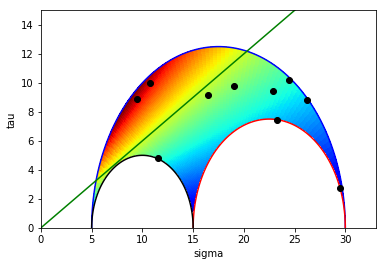

In [11]:
#### defining the current state of our faults
azimuth_shmin=0; azimuth_shmax=azimuth_shmin+90; S_hmin=20; S_hmax=30;Sv=45;Pp=15; mu=0.6
#### creting 10 random orientaiton and dips of faults
striker= 360*np.linspace(0.1,1,num=10)
dipr= 90*np.random.rand(10)
#### Plotting Mohr circles
S1,S2,S3,fault_regime=TypeFaulting(Sv,S_hmax,S_hmin)
fig1=MohrCircle(S1,S2,S3,Pp,mu)
#### plot the random faults inside the mohr circle
#gotta obtain the transformation matrix and angles
a,b,y=angle_transform(fault_regime,azimuth_shmax,azimuth_shmin)
S_p,Rpg,Sg=Matrix_transforms(S1,S2,S3,a,b,y)
for i in range (len(striker)):
    n_n, n_s, n_d=new_cordinates(striker[i],dipr[i])
    Sn, T_abs=oblique_stress_strain(Sg,n_n,n_s,n_d)
    plt.plot((Sn-Pp),T_abs,'ko')
plt.xlabel("sigma")
plt.ylabel("tau")


lets make the stereonet

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  
C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.


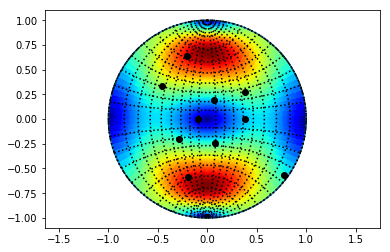

In [12]:
#creating the stereonent color
ster_outline()
strikes=np.linspace(0,360,num=100)
dips=np.linspace(0, 90, num=100)
color_ster(strikes,dips,Sg)
#plotting the random points
for i in range (len(striker)):
    point_ster(striker[i],dipr[i])